In [62]:
import os
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from pyproj import Transformer, transform

import warnings
warnings.simplefilter("ignore")

In [63]:
# File locations
gpsDataDirRaw = "./data/gps/raw"
gpsDataDirCsv = "./data/gps/csv"
windMobileDataDirRaw = "./data/wind/mobile/raw"
windMobileDataDirCsv = "./data/wind/mobile/csv"
windStaticDataDirRaw = "./data/wind/static/raw"
windStaticDataDirCsv = "./data/wind/static/csv"

# Static coordinates, deg
## Static/Reference anemometer
lat_ref_deg = 35.575785
lon_ref_deg = 139.670174
east_ref_m = 379503.820
north_ref_m = 3937712.089

# Distances
long_track_NW_wing = 318.11     # (m) long track NW turning distance, near the bridge
long_track_SE_wing = 248.30     # (m) long track SE turning distance, near the yellow ground with Hello Cycling
short_track_NW_wing = 19.00     # (m) short track NW turning distance, close to the small stony road
short_track_SE_wing = 27.39     # (m) short track SE turning distance, near the black futon
long_track_shorter_wing = np.min([long_track_NW_wing, long_track_SE_wing])
short_track_shorter_wing = np.min([short_track_NW_wing, short_track_SE_wing])

# Short & Long track experiment list
long_track_start_times = [
    "12:18:32",
    "12:40:00",
    "13:03:33",
    "14:52:01",
    "15:12:13"
]
short_track_start_times = [
    "13:33:28",
    "13:47:59",
    "14:18:00",
    "14:35:01"
]

# Deviated angle of North direction
## Angle between the North direction of static anemometer, and the true geographical North direction
north_dev_angle = 22.834        # (deg)

# I. Data wrangling

## 1. GPS

For each GPX file:
- Convert GPX-encoded data to relational table, including cols:
    + `timestamp_id`: Timestamp (`yyyy-mm-dd hh:mm:ss+00:00`, UTC).
    + `timestamp_hhmmss_jst`: Timestamp (`hh:mm:ss`, JST).
    + `lat_deg`: Latitude (degree) - WGS:84 system.
    + `lon_deg`: Longitude (degree) - WGS:84 system.
    + `elevation`: Elevation (m).
    + `east_m`: Easting (m) - UTM system.
    + `north_m`: Northing (m) - UTM system.
    + `speed`: Speed (m/s).
    + `bearing`: East: 0 & 360 deg; North: 90 deg; West: 180 deg; South: 270 deg.
    + `distance_to_ref_point`: (m) distance to reference observation point, a.k.a static anemometer.
    + `status`: current status of movement, there are 3 types:
        + `northward`: when the observer moves North.
        + `southward`: when the observer moves South.
        + `turning`: the timestamps when the mobile observer conducted a turn-back maneuver, in which data becomes unreliable.
- 

### a. Auxiliary functions

In [64]:
# [Row-wise] Function to convert deg coordinates to metre coordinates
# I tried different UTM CRS codes and selected the one with lowest distance error
# EPSG 3100 is for Japan Tokyo (UTM zone code 54N)
# Ref: https://epsg.io/3100
transformer = Transformer.from_crs(
    4326, 3100,
    always_xy = True
)
def latlon_deg2Meter(row):
    x, y = transformer.transform(
        row["lon_deg"],
        row["lat_deg"]
    )
    # print(f"{x}\t{y}")

    return pd.Series([x, y])

# Function to calculate speed in meters and bearing in degrees for mobile observer
# East: 0 & 360 deg; North: 90 deg; West: 180 deg; South: 270 deg
def cal_speed_m_bearing_deg(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    speed = math.sqrt(dx**2 + dy**2)    # meter. Note that this is because this DF is 1-second frequency
    angle = np.arctan2(dy, dx)          # rad
    angle_deg = np.degrees(angle)       # deg
    bearing = (angle_deg + 360) % 360   # deg (0 - 360)
    
    return [speed, bearing]

# [Row-wise] Function to calculate distance from mobile to static anemometer, in meters
# xm, ym: meter-coordinates of mobile anemometer
def cal_dist_to_static(row):
    xm = row["east_m"]
    ym = row["north_m"]
    dx = east_ref_m - xm
    dy = north_ref_m - ym
    # print(f"{dx}\t{dy}")
    dist = math.sqrt(dx**2 + dy**2)

    return dist

### b. Execute

In [65]:
# A grand dataframe to join multiple experiments together
df_gps_total = pd.DataFrame()

for gpxFileName in os.listdir(gpsDataDirRaw):

    # ================== Convert GPX to CSV with `timestamp`, `lat`, `lon` & `elevation` ================== #
    gpxFile = os.path.join(gpsDataDirRaw, gpxFileName)
    tree = ET.parse(gpxFile)
    root = tree.getroot()

    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}

    data = []

    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.get('lat'))
        lon = float(trkpt.get('lon'))
        ele = float(trkpt.find('default:ele', namespace).text)
        time = trkpt.find('default:time', namespace).text

        data.append([time, lat, lon, ele])

    df = pd.DataFrame(
        data,
        columns = [
            'timestamp_id', 
            'lat_deg', 
            'lon_deg', 
            'elevation'
        ]
    )

    # ================== Convert timestamp to Tokyo (UTC + 9) ================== #

    df["timestamp_id"] = pd.to_datetime(
        df["timestamp_id"],
        utc = True
    ).dt.tz_convert("Asia/Tokyo")

    # ================== Add another timestamp but only hh:mm:ss (all experiments on same day) and in JST (UTC + 9) ================== #

    df["timestamp_hhmmss_jst"] = df["timestamp_id"].dt.strftime("%H:%M:%S")
    df["timestamp_hhmmss_jst"] = pd.to_datetime(
        df["timestamp_hhmmss_jst"],
        format = "%H:%M:%S"
    ).dt.time

    outputName = str(df.at[0, "timestamp_hhmmss_jst"]) + "-" + str(df.at[len(df) - 1, "timestamp_hhmmss_jst"]) + ".csv"

    # ================== Add `lat_m` and `lon_m` which are converted from `lat_deg` and `lon_deg` ================== #

    df[["east_m", "north_m"]] = df.apply(
        latlon_deg2Meter,
        axis = 1
    )

    # ================== Add `speed` and `bearing` ================== #

    list_speed = []
    list_bearing = []
    for i in range(1, len(df)):
        [speed, bearing] = cal_speed_m_bearing_deg(
            df.iloc[i-1]["east_m"],
            df.iloc[i-1]["north_m"], 
            df.iloc[i]["east_m"],
            df.iloc[i]["north_m"])
        list_speed.append(speed)
        list_bearing.append(bearing)
    list_speed = [0] + list_speed
    list_bearing = [list_bearing[0]] + list_bearing
    df["speed"] = list_speed
    df["bearing"] = list_bearing

    # ================== Add `distance_to_ref_point` ================== #

    df["distance_to_ref_point"] = df.apply(
        cal_dist_to_static,
        axis = 1
    )

    # ================== Add `status` flag ================== #
    # `turning` if `distance_to_ref_point`` is >= 90% of the shorter wing between NW and SE wings.
    
    min_dist = df["distance_to_ref_point"].min()
    if str(df.at[0, "timestamp_hhmmss_jst"]) in long_track_start_times:
        max_dist = long_track_shorter_wing
    elif str(df.at[0, "timestamp_hhmmss_jst"]) in short_track_start_times:
        max_dist = short_track_shorter_wing
    else:
        print(f"Cannot determine this file \"{gpxFileName}\" belongs to which track, terminating.")
        exit(1)
    df["status"] = np.where(
        df["distance_to_ref_point"] >= min_dist + 0.9 * (max_dist - min_dist),
        "turning",
        np.where(
            df["bearing"] < 180,
            "northward",
            "southward"
        )
    )

    # ================== Downsample to 10 Hz or 100ms frequency ================== #

    df.set_index(
        "timestamp_id",
        inplace = True
    )

    df = df.resample("100ms").interpolate("linear").bfill()

    # ================== Save as "hh:mm:ss-hh:mm:ss.csv" ================== #
    # The 2 timestamps being the beginning and the end of experiment

    outputCSVPath = os.path.join(gpsDataDirCsv, outputName)

    df.to_csv(outputCSVPath, index=False)

    # Also rename the GPX file for better management later
    newPathGPX = os.path.join(
        gpsDataDirRaw,
        outputName.replace(".csv", ".gpx")
    )
    os.rename(gpxFile, newPathGPX)

    print(f"Finished {gpxFileName}")

    df_gps_total = pd.concat([df_gps_total, df])

# ================== Finalize the Total GPS dataframe ================== #

df_gps_total.sort_values(
    by = "timestamp_id",
    ascending = True,
    inplace = True
)

df_gps_total.drop(
    columns = ["timestamp_hhmmss_jst"],
    inplace = True
)

df_gps_total.to_csv(
    os.path.join(
        gpsDataDirCsv,
        "total_gps.csv"
    )
)

print(f"Finished merging into one total_gps.csv")

Finished 15:12:13-15:23:57.gpx
Finished 14:18:00-14:27:44.gpx
Finished 14:35:01-14:45:48.gpx
Finished 12:40:00-12:54:57.gpx
Finished 13:03:33-13:16:26.gpx
Finished 12:18:32-12:34:00.gpx
Finished 13:47:59-13:52:41.gpx
Finished 14:52:01-15:05:36.gpx
Finished 13:33:28-13:43:11.gpx
Finished merging into one total_gps.csv


## 2. Wind - mobile observer

In [66]:
# A grand dataframe to join multiple dataframes together
df_wind_mobile_total = pd.DataFrame()

for windMobileFileName in os.listdir(windMobileDataDirRaw):

    # ================== Read TXT to CSV with corresponding columns ================== #

    txtFilePath = os.path.join(windMobileDataDirRaw, windMobileFileName)
    df = pd.read_csv(
        txtFilePath,
        index_col = False,
        header = None,
        engine = "python",
        sep = r',\s*|\s+',
        names = [
            "date", "time", "sub_second_id",
            "v", "u", "w",      # Here I swap u and v as Alex said
            "pitch", "roll"
        ]
    )

    df["date_time"] = df["date"].astype(str) + " " + df["time"].astype(str)

    # ================== Resample from 40 Hz to 10 Hz so it matches frequency of static one ================== #

    agg_rules = {
        "date_time": "first",
        "time": "first",
        "sub_second_id": "first",
        "u": "mean",
        "v": "mean",
        "w": "mean",
        "pitch": "mean",
        "roll": "mean",
    }

    df = df.groupby([
        df["date_time"],
        df.groupby(df["date_time"]).cumcount() // 4
    ]).agg(agg_rules).round(decimals = 4)

    df["sub_second_id"] = df.groupby("time").cumcount() * 100

    df["timestamp_id"] = pd.to_datetime(
        df["date_time"].astype(str) + " " + df["sub_second_id"].astype(str),
        format = "%Y%m%d %H:%M:%S %f"
    )

    # ================== 35 second offset to mobile observer data as Alex said ================== #

    df["timestamp_id"] = df["timestamp_id"] + pd.Timedelta("35s")

    df.drop(
        ["date_time"],
        axis = 1,
        inplace = True
    )

    df = df[[
        "timestamp_id",
        "time", "sub_second_id",
        "u", "v", "w",
        "pitch", "roll"
    ]]

    # ================== Get wind speed on XY plane ================== #

    df["wind_speed_mobile"] = np.sqrt(df["u"]**2 + df["v"]**2)

    # ================== Output as CSV ================== #

    df.rename(
        columns = {
            "time": "timestamp_hhmmss_jst",
            "sub_second_id": "ms",
            "u": "u_mobile",
            "v": "v_mobile",
            "w": "w_mobile"
        },
        inplace = True
    )

    df.to_csv(
        os.path.join(
            windMobileDataDirCsv,
            windMobileFileName.replace(".txt", ".csv")
        ),
        index = False
    )

    print(f"Finished {windMobileFileName}")

    df_wind_mobile_total = pd.concat([df_wind_mobile_total, df])

df_wind_mobile_total.sort_values(
    by = "timestamp_id",
    ascending = True,
    inplace = True
)

df_wind_mobile_total.to_csv(
    os.path.join(
        windMobileDataDirCsv,
        "total_wind_mobile.csv"
    ),
    index = False
)

print(f"Finished merging into one total_wind_mobile.csv")

Finished AML-008-20240426_1200.txt
Finished AML-008-20240426_1600.txt
Finished AML-008-20240426_1300.txt
Finished AML-008-20240426_1500.txt
Finished AML-008-20240426_1530.txt
Finished AML-008-20240426_1330.txt
Finished AML-008-20240426_1430.txt
Finished AML-008-20240426_1230.txt
Finished merging into one total_wind_mobile.csv


## 3. Wind - static observer

In [67]:
df_wind_static_total = pd.read_csv(
    os.path.join(
        windStaticDataDirRaw,
        "raw_static_data.csv"
    ),
    delimiter = ",",
    index_col = False
)

df_wind_static_total["timestamp_id"] = pd.to_datetime(
    df_wind_static_total["timestamp_id"],
    utc = True
)

df_wind_static_total["timestamp_hhmmss_jst"] = df_wind_static_total["timestamp_id"].dt.strftime("%H:%M:%S")

df_wind_static_total.drop(
    ["NO.", "A1234567890", "A123456789"],
    axis = 1,
    inplace = True
)

for col in ["u", "v", "w", "temp_c"]:
    df_wind_static_total.drop(
        df_wind_static_total[df_wind_static_total[col] == "+++++++"].index,
        inplace = True
    )
    df_wind_static_total[col] = pd.to_numeric(
        df_wind_static_total[col],
        errors = "coerce"
    )
df_wind_static_total.dropna(inplace = True)

# ================== Get wind bearing on XY plane, same rule as bearing of GPS ================== #

df_wind_static_total["wind_bearing_static"] = (np.degrees(
    np.arctan2(df_wind_static_total["v"], df_wind_static_total["u"])
) + 360 + north_dev_angle) % 360

# ================== Get wind speed on XY plane ================== #

df_wind_static_total["wind_speed_static"] = np.sqrt(df_wind_static_total["u"]**2 + df_wind_static_total["v"]**2)
df_wind_static_total.drop(
    df_wind_static_total[df_wind_static_total["wind_speed_static"] > 12].index,
    inplace = True
)

# ================== Finalize and save ================== #

df_wind_static_total.rename(
    columns = {
        "u": "u_static",
        "v": "v_static",
        "w": "w_static",
        "temp_c": "temp_c_static"
    },
    inplace = True
)

df_wind_static_total = df_wind_static_total[[
    "timestamp_id",
    "timestamp_hhmmss_jst",
    "ms",
    "u_static",
    "v_static",
    "w_static",
    "wind_bearing_static",
    "wind_speed_static",
    "temp_c_static"
]]

df_wind_static_total.to_csv(
    os.path.join(
        windStaticDataDirCsv,
        "total_wind_static.csv"
    ),
    index = False
)

## 4. Merge tables

### a. Merge 2 wind tables

In [68]:
df_wind = pd.merge(
    df_wind_static_total,
    df_wind_mobile_total,
    on = ["timestamp_hhmmss_jst", "ms"],
    how = "left"
)

df_wind["ms"] = df_wind["ms"].astype(str)
df_wind.loc[df_wind["ms"] == "0", "ms"] = "000"

df_wind["timestamp_id"] = "2024-04-26 " + df_wind["timestamp_hhmmss_jst"] + "." + df_wind["ms"]
df_wind["timestamp_id"] = pd.to_datetime(
    df_wind["timestamp_id"],
    format = "%Y-%m-%d %H:%M:%S.%f"
).dt.tz_localize("Asia/Tokyo")

df_wind.drop(columns = [
    "timestamp_id_x",
    "timestamp_id_y"
], inplace = True)

df_wind = df_wind[[
    "timestamp_id", "timestamp_hhmmss_jst",
    "u_static", "v_static", "w_static", "wind_bearing_static", "wind_speed_static", "temp_c_static",
    "u_mobile", "v_mobile", "w_mobile", "wind_speed_mobile"
]]

df_wind.set_index(
    "timestamp_id",
    inplace = True
)

df_wind.drop(
    columns = ["timestamp_hhmmss_jst"],
    inplace = True
)

df_wind.to_csv("./data/wind/total_wind.csv")

### b. Merge wind table with GPS table

In [69]:
df_master = df_wind.join(
    df_gps_total,
    how = "inner"
)

# ================== Get wind bearing on XY plane of mobile observer ================== #
# Depends on northward/southward movements

df_master["north_dev_angle"] = np.where(
    df_master["status"] == "northward",
    north_dev_angle,
    np.where(
        df_master["status"] == "southward",
        north_dev_angle - 180,
        np.nan
    )
)

df_master["wind_bearing_mobile"] = np.where(
    df_master["status"] == "turning",
    np.nan,
    (np.degrees(
        np.arctan2(
            df_master["v_mobile"], 
            df_master["u_mobile"]
        )
    ) + 360 + df_master["north_dev_angle"]) % 360
)

### c. Feature engineering - theory: `wind_static - movement = wind_mobile` near ref. point

In [70]:
# Convert bearings to radians
df_master['wind_bearing_static_rad'] = np.deg2rad(df_master['wind_bearing_static'])
df_master['gps_bearing_rad'] = np.deg2rad(df_master['bearing'])

# Calculate vector components
df_master['x_windstatic_speed'] = df_master['wind_speed_static'] * np.cos(df_master['wind_bearing_static_rad'])
df_master['y_windstatic_speed'] = df_master['wind_speed_static'] * np.sin(df_master['wind_bearing_static_rad'])
df_master['x_gps_speed'] = df_master['speed'] * np.cos(df_master['gps_bearing_rad'])
df_master['y_gps_speed'] = df_master['speed'] * np.sin(df_master['gps_bearing_rad'])

# Combine vector components
df_master['x_windstatic_gps_combined'] = df_master['x_windstatic_speed'] - df_master['x_gps_speed']
df_master['y_windstatic_gps_combined'] = df_master['y_windstatic_speed'] - df_master['y_gps_speed']

# Calculate combined speed and bearing
df_master['combined_speed'] = np.sqrt(df_master['x_windstatic_gps_combined']**2 + df_master['y_windstatic_gps_combined']**2)
df_master['combined_bearing'] = np.degrees(np.arctan2(
    df_master['y_windstatic_gps_combined'], 
    df_master['x_windstatic_gps_combined']
))

# Normalize combined_bearing to 0-360 degrees
df_master['combined_bearing'] = (df_master['combined_bearing'] + 360) % 360

df_master.drop(
    columns = [
        'wind_bearing_static_rad', 'gps_bearing_rad', 
        'x_windstatic_speed', 'y_windstatic_speed', 'x_gps_speed', 'y_gps_speed',
        'x_windstatic_gps_combined', 'y_windstatic_gps_combined',
    ],
    inplace = True
)

# Errors between combined and mobile
df_master["error_speed"] = np.abs(df_master["combined_speed"] - df_master["wind_speed_mobile"])
df_master["error_bearing"] = np.abs(df_master["combined_bearing"] - df_master["wind_bearing_mobile"])

# Ref. point proximity
proximity_threshold = 2
df_master["ref_proximity"] = np.where(
    df_master["distance_to_ref_point"] <= proximity_threshold,
    True, False
)

### d. Export

In [71]:
df_master.to_csv("./data/master.csv")

# II. EDA

## 1. GPS data

### a. Distance to Reference point

In [72]:
exp_long_1 = df_master.loc[
    (df_master.index >= "2024-04-26 12:18:00+09:00") &
    (df_master.index <= "2024-04-26 12:35:00+09:00")
]
exp_long_2 = df_master.loc[
    (df_master.index >= "2024-04-26 12:35:00+09:00") &
    (df_master.index <= "2024-04-26 12:56:00+09:00")
]
exp_long_3 = df_master.loc[
    (df_master.index >= "2024-04-26 13:00:00+09:00") &
    (df_master.index <= "2024-04-26 13:30:00+09:00")
]

exp_short_4 = df_master.loc[
    (df_master.index >= "2024-04-26 13:30:00+09:00") &
    (df_master.index <= "2024-04-26 13:45:00+09:00")
]
exp_short_5 = df_master.loc[
    (df_master.index >= "2024-04-26 13:45:00+09:00") &
    (df_master.index <= "2024-04-26 14:00:00+09:00")
]
exp_short_6 = df_master.loc[
    (df_master.index >= "2024-04-26 14:00:00+09:00") &
    (df_master.index <= "2024-04-26 14:30:00+09:00")
]
exp_short_7 = df_master.loc[
    (df_master.index >= "2024-04-26 14:30:00+09:00") &
    (df_master.index <= "2024-04-26 14:46:00+09:00")
]

exp_long_8 = df_master.loc[
    (df_master.index >= "2024-04-26 14:46:00+09:00") &
    (df_master.index <= "2024-04-26 15:10:00+09:00")
]
exp_long_9 = df_master.loc[
    (df_master.index >= "2024-04-26 15:10:00+09:00") &
    (df_master.index <= "2024-04-26 15:25:00+09:00")
]

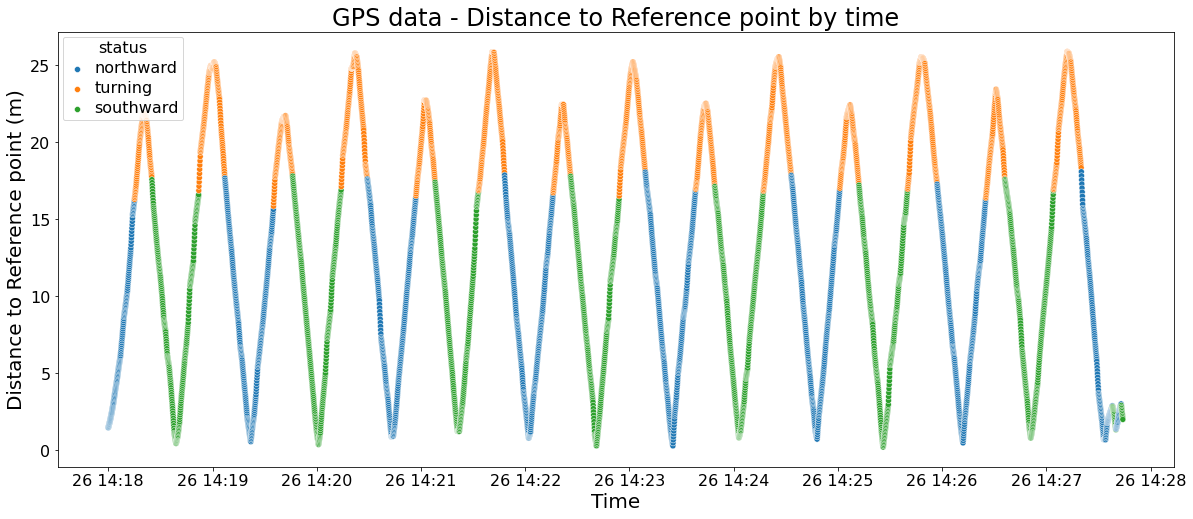

In [73]:
plt.figure(figsize = (20, 8))
graph = sns.scatterplot(
    x = exp_short_6.index,
    y = exp_short_6["distance_to_ref_point"],
    hue = exp_short_6["status"],
)
plt.title("GPS data - Distance to Reference point by time", fontsize = 24)
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Distance to Reference point (m)", fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.setp(graph.get_legend().get_title(), fontsize = "16")
plt.setp(graph.get_legend().get_texts(), fontsize = "16")
plt.show()

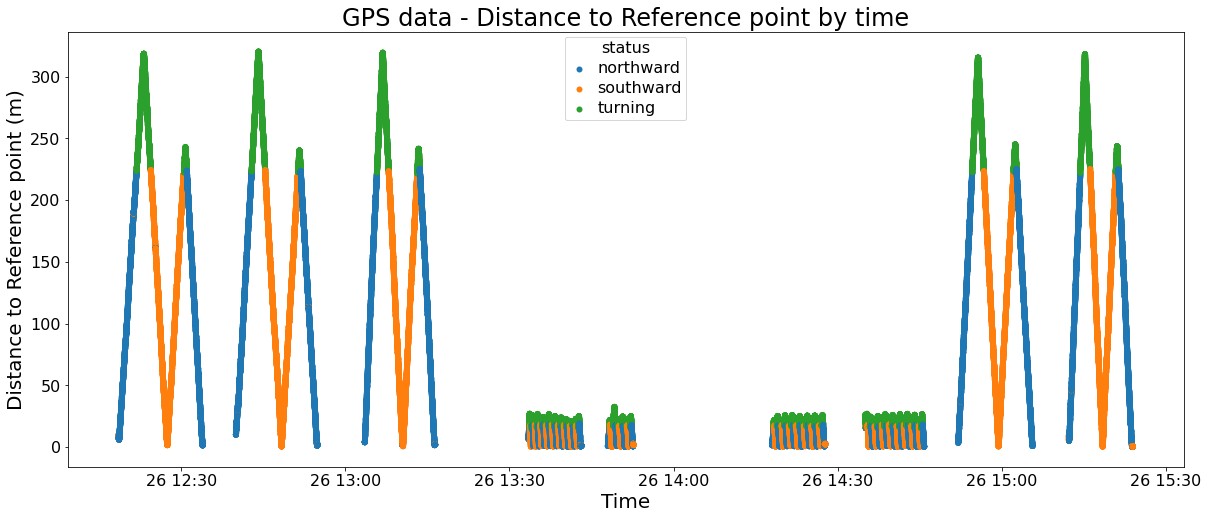

In [74]:
plt.figure(figsize = (20, 8))
graph = sns.scatterplot(
    x = df_gps_total.index,
    y = df_gps_total["distance_to_ref_point"],
    hue = df_gps_total["status"],
    linewidth = 0,
)
plt.title("GPS data - Distance to Reference point by time", fontsize = 24)
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Distance to Reference point (m)", fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.setp(graph.get_legend().get_title(), fontsize = "16")
plt.setp(graph.get_legend().get_texts(), fontsize = "16")
plt.show()

### b. Speed

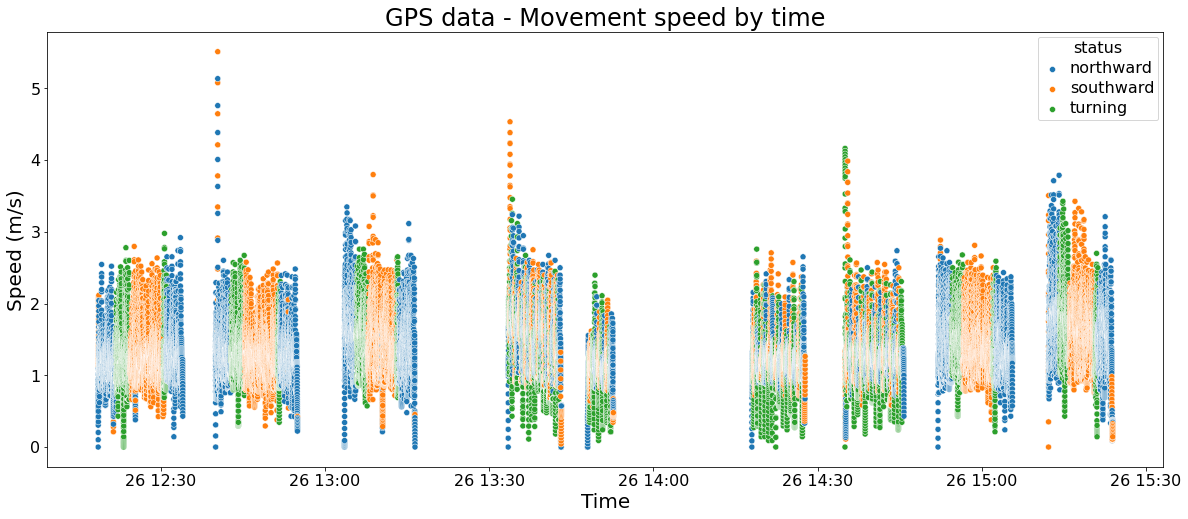

In [75]:
plt.figure(figsize = (20, 8))
graph = sns.scatterplot(
    x = df_gps_total.index,
    y = df_gps_total["speed"],
    hue = df_gps_total["status"],
)
plt.title("GPS data - Movement speed by time", fontsize = 24)
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Speed (m/s)", fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.setp(graph.get_legend().get_title(), fontsize = "16")
plt.setp(graph.get_legend().get_texts(), fontsize = "16")
plt.show()

### c. Bearing

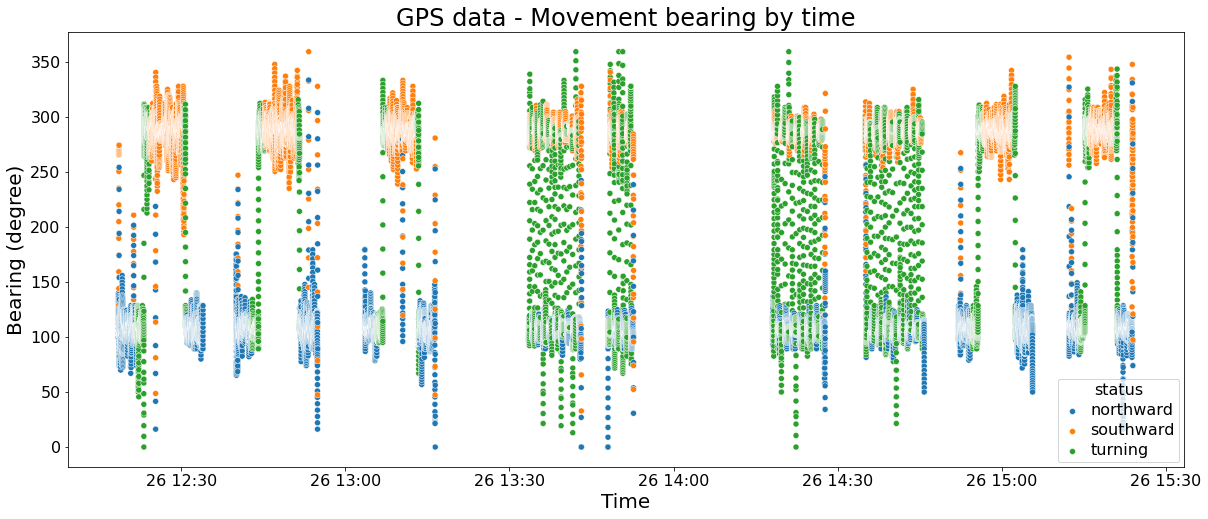

In [76]:
plt.figure(figsize = (20, 8))
graph = sns.scatterplot(
    x = df_gps_total.index,
    y = df_gps_total["bearing"],
    hue = df_gps_total["status"]
)
plt.title("GPS data - Movement bearing by time", fontsize = 24)
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Bearing (degree)", fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.setp(graph.get_legend().get_title(), fontsize = "16")
plt.setp(graph.get_legend().get_texts(), fontsize = "16")
plt.show()

## 2. Wind

### a. Static anemometer

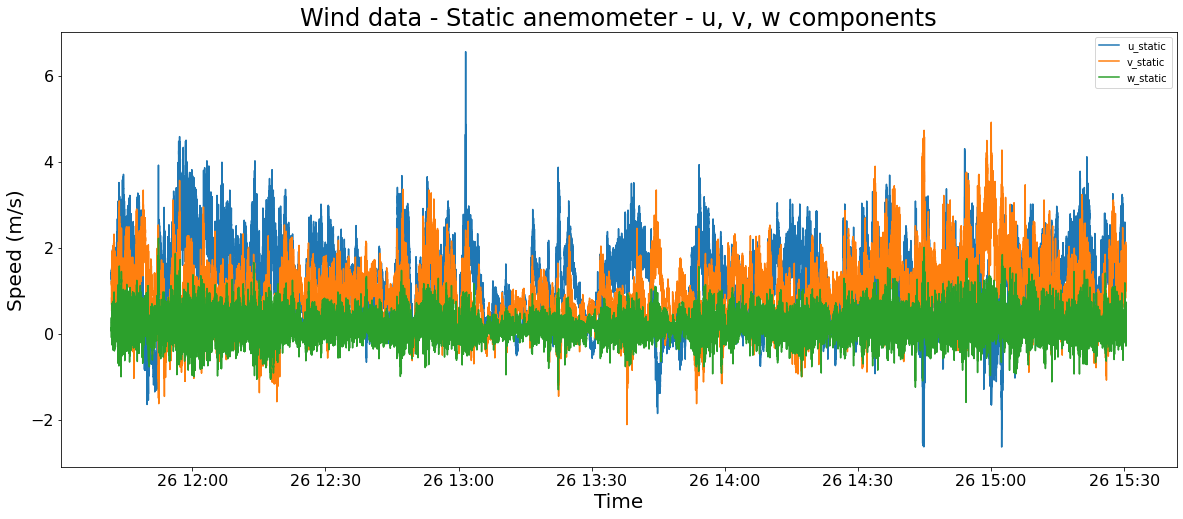

In [77]:
plt.figure(figsize = (20, 8))
for col in ["u_static", "v_static", "w_static"]:
    sns.lineplot(
        x = df_wind.index,
        y = df_wind[col],
        label = col
    )
plt.title("Wind data - Static anemometer - u, v, w components", fontsize = 24)
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Speed (m/s)", fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.setp(graph.get_legend().get_title(), fontsize = "16")
plt.setp(graph.get_legend().get_texts(), fontsize = "32")
plt.show()

Text(0, 0.5, 'Speed (m/s)')

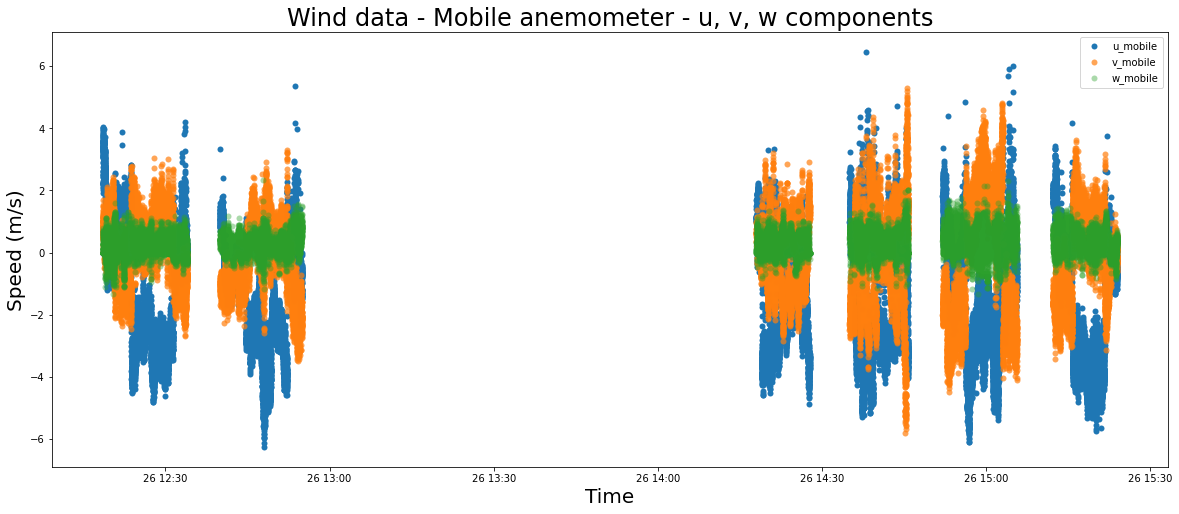

In [78]:
plt.figure(figsize = (20, 8))
for col in [
    ["u_mobile", 1],
    ["v_mobile", 0.7],
    ["w_mobile", 0.4]
]:
    sns.scatterplot(
        x = df_master.index,
        y = df_master[col[0]],
        label = col[0],
        alpha = col[1],
        linewidth = 0
    )
plt.title(
    "Wind data - Mobile anemometer - u, v, w components", 
    fontsize = 24
)
plt.xlabel(
    "Time", 
    fontsize = 20
)
plt.ylabel(
    "Speed (m/s)", 
    fontsize = 20
)

# III. Testing theory

In [79]:
# Split experiments
list_exp = {
    "exp_long_1": exp_long_1, 
    "exp_long_2": exp_long_2, 
    "exp_long_3_failed": exp_long_3,
    "exp_short_4_failed": exp_short_4,
    "exp_short_5_failed": exp_short_5, 
    "exp_short_6": exp_short_6, 
    "exp_short_7": exp_short_7,
    "exp_long_8": exp_long_8, 
    "exp_long_9": exp_long_9
}

result_theory1_dir_speed = "./results/theory_1/speed"
result_theory1_dir_bearing = "./results/theory_1/bearing"

## 1. `wind_static + movement = wind_mobile`

### a. Speed errors

In [80]:
# Speed comparison

for name_exp in list_exp:

    df_exp = list_exp[name_exp]

    # Comparison figure

    plt.figure(figsize = (20, 8))

    for _, dfseg in df_exp.groupby("ref_proximity"):
        if _ == True:
            proximity_alpha = 1
        else:
            proximity_alpha = 0.05
        print(f"Proximity to ref. point < {proximity_threshold} m : {_}")
        sns.scatterplot(
            x = dfseg.index,
            y = dfseg["wind_speed_mobile"],
            color = "r",
            alpha = proximity_alpha,
            label = "Wind speed (mobile observer)",
        )
        sns.scatterplot(
            x = dfseg.index,
            y = dfseg["combined_speed"],
            color = "g",
            alpha = proximity_alpha,
            label = "Wind speed (static wind & movement vector combined)",
        )

    plt.title(f"{name_exp} - Theory test - Speed comparison", fontsize = 24)
    plt.xlabel("Time", fontsize = 20)
    plt.ylabel("Speed (m/s)", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 15)

    if not os.path.exists(result_theory1_dir_speed):
        os.makedirs(result_theory1_dir_speed)
    plt.savefig(
        os.path.join(
            result_theory1_dir_speed, 
            f"speed_comparison_{name_exp}.png"
        )
    )
    plt.close()

    # Error figure

    plt.figure(figsize = (20, 8))

    sns.scatterplot(
        x = dfseg.index,
        y = dfseg["error_speed"],
        color = "r",
    )

    plt.title(f"{name_exp} - Theory test - Speed errors", fontsize = 24)
    plt.xlabel("Time", fontsize = 20)
    plt.ylabel("Speed (m/s)", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    if not os.path.exists(result_theory1_dir_speed):
        os.makedirs(result_theory1_dir_speed)
    plt.savefig(
        os.path.join(
            result_theory1_dir_speed, 
            f"speed_error_{name_exp}.png"
        )
    )
    plt.close()

    print(f"Finished {name_exp}")

Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_long_1
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_long_2
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_long_3_failed
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_short_4_failed
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_short_5_failed
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_short_6
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_short_7
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_long_8
Proximity to ref. point < 2 m : False
Proximity to ref. point < 2 m : True
Finished exp_long_9


In [81]:
# Bearing comparison

for name_exp in list_exp:

    df_exp = list_exp[name_exp]

    plt.figure(figsize = (20, 8))

    for _, dfseg in df_exp.groupby("ref_proximity"):
        if _ == True:
            proximity_alpha = 1
        else:
            proximity_alpha = 0.05
        sns.scatterplot(
            x = dfseg.index,
            y = dfseg["wind_bearing_mobile"],
            color = "r",
            alpha = proximity_alpha,
            label = "Wind bearing (mobile observer)",
        )
        sns.scatterplot(
            x = dfseg.index,
            y = dfseg["combined_bearing"],
            color = "g",
            alpha = proximity_alpha,
            label = "Wind bearing (static wind & movement vector combined)",
        )

    plt.title(f"{name_exp} - Theory test - Bearing comparison", fontsize = 24)
    plt.xlabel("Time", fontsize = 20)
    plt.ylabel("Bearing (degree)", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 15)

    if not os.path.exists(result_theory1_dir_bearing):
        os.makedirs(result_theory1_dir_bearing)
    plt.savefig(
        os.path.join(
            result_theory1_dir_bearing, 
            f"bearing_comparison_{name_exp}.png"
        )
    )
    plt.close()

    # Error figure

    plt.figure(figsize = (20, 8))

    sns.scatterplot(
        x = dfseg.index,
        y = dfseg["error_bearing"],
        color = "r",
    )

    plt.title(f"{name_exp} - Theory test - Bearing errors", fontsize = 24)
    plt.xlabel("Time", fontsize = 20)
    plt.ylabel("Bearing (degree)", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    if not os.path.exists(result_theory1_dir_bearing):
        os.makedirs(result_theory1_dir_bearing)
    plt.savefig(
        os.path.join(
            result_theory1_dir_bearing, 
            f"bearing_error_{name_exp}.png"
        )
    )
    plt.close()

    print(f"Finished {name_exp}")

Finished exp_long_1
Finished exp_long_2
Finished exp_long_3_failed
Finished exp_short_4_failed
Finished exp_short_5_failed
Finished exp_short_6
Finished exp_short_7
Finished exp_long_8
Finished exp_long_9
